In [1]:
import torch
import torchmetrics

import matplotlib.pyplot as plt

from torch import nn
from sklearn.datasets import make_blobs
from sklearn.model_selection import train_test_split

In [2]:
torch.cuda.is_available()

True

In [3]:
NUM_SAMPLES = 2000

NUM_CLASSES = 4
NUM_FEATURES = 2

RANDOM_SEED = 123

In [4]:
# Create multi-class data
X, y = make_blobs(
    n_samples=NUM_SAMPLES, 
    n_features=NUM_FEATURES,
    centers=NUM_CLASSES,
    cluster_std=1.2,
    random_state=RANDOM_SEED
)

In [5]:
# Data to tensors
X = torch.from_numpy(X).type(torch.float)
y = torch.from_numpy(y).type(torch.LongTensor)

In [6]:
X[:3], y[:3]

(tensor([[ 3.9259,  0.2720],
         [ 9.2042,  4.3108],
         [ 2.1618, -4.2700]]),
 tensor([2, 3, 0]))

In [7]:
# Train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=RANDOM_SEED)

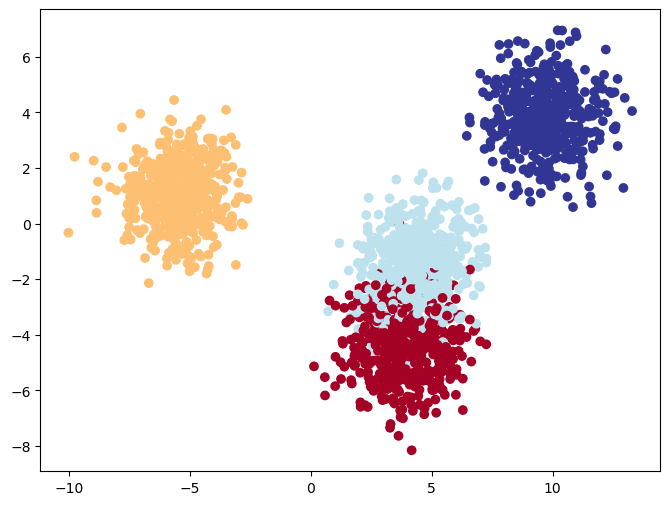

In [8]:
plt.figure(figsize=(8, 6))
plt.scatter(X[:,0], X[:,1], c=y, cmap=plt.cm.RdYlBu);

In [9]:
# Build a multi-class classifier

In [9]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [10]:
class Model(nn.Module):
    def __init__(self, input_features, output_features, hidden_units=8):
        super().__init__()
        self.layers = nn.Sequential(
            nn.Linear(input_features, hidden_units),
            nn.ReLU(),
            nn.Linear(hidden_units, hidden_units),
            nn.ReLU(),
            nn.Linear(hidden_units, output_features)
        )
        
    def forward(self, x):
        return self.layers(x)

In [12]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device 

'cuda'

In [13]:
model = Model(NUM_FEATURES, NUM_CLASSES).to(device)
model

Model(
  (layers): Sequential(
    (0): Linear(in_features=2, out_features=8, bias=True)
    (1): ReLU()
    (2): Linear(in_features=8, out_features=8, bias=True)
    (3): ReLU()
    (4): Linear(in_features=8, out_features=4, bias=True)
  )
)

In [14]:
# Define loss criterion and optimizer for model weights

In [15]:
loss_fn = nn.CrossEntropyLoss()

optimizer = torch.optim.SGD(model.parameters(), lr=0.1)

In [16]:
# First try
model(X_train.to(device))[:5], model(X_train.to(device))[:5][0].shape, NUM_CLASSES

(tensor([[ 0.1996, -0.2003, -0.3634, -0.7671],
         [ 0.2484, -0.3497, -0.0835,  0.1251],
         [ 0.1822,  0.0653, -0.0972,  0.0102],
         [ 0.1323, -0.1024, -0.1597, -0.4924],
         [ 0.2469, -0.2399, -0.4578, -0.8446]], device='cuda:0',
        grad_fn=<SliceBackward0>),
 torch.Size([4]),
 4)

In [17]:
# SOftmax
y5 = model(X_train[:5].to(device))
y5, y5.shape

(tensor([[ 0.1996, -0.2003, -0.3634, -0.7671],
         [ 0.2484, -0.3497, -0.0835,  0.1251],
         [ 0.1822,  0.0653, -0.0972,  0.0102],
         [ 0.1323, -0.1024, -0.1597, -0.4924],
         [ 0.2469, -0.2399, -0.4578, -0.8446]], device='cuda:0',
        grad_fn=<AddmmBackward0>),
 torch.Size([5, 4]))

In [18]:
torch.softmax(y5, dim=1), torch.softmax(y5, dim=1).sum(dim=1)

(tensor([[0.3817, 0.2559, 0.2173, 0.1451],
         [0.3173, 0.1745, 0.2277, 0.2805],
         [0.2867, 0.2551, 0.2168, 0.2414],
         [0.3254, 0.2573, 0.2430, 0.1742],
         [0.4091, 0.2514, 0.2022, 0.1373]], device='cuda:0',
        grad_fn=<SoftmaxBackward0>),
 tensor([1., 1., 1., 1., 1.], device='cuda:0', grad_fn=<SumBackward1>))

In [19]:
# which class? use argmax
y1 = torch.softmax(y5, dim=1)[2,:]
y1, torch.argmax(y1), y1[torch.argmax(y1)]

(tensor([0.2867, 0.2551, 0.2168, 0.2414], device='cuda:0',
        grad_fn=<SliceBackward0>),
 tensor(0, device='cuda:0'),
 tensor(0.2867, device='cuda:0', grad_fn=<SelectBackward0>))

In [20]:
# Training loop

In [21]:
torch_acc = torchmetrics.Accuracy(task="multiclass", num_classes=NUM_CLASSES).to(device)

In [22]:
torch.manual_seed(RANDOM_SEED)

epochs = 200

X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)

In [23]:
for epoch in range(epochs):
    
    # Training
    
    model.train()
    
    y_logits = model(X_train)
    y_pred = torch.softmax(y_logits, dim=1).argmax(dim=1)
    
    loss = loss_fn(y_logits, y_train)
    acc = torch_acc(y_pred, y_train).item()
    
    optimizer.zero_grad()
    
    loss.backward()
    
    optimizer.step()
    
    # Test within epoch
    
    model.eval()
    with torch.inference_mode():
        y_test_logits = model(X_test)
        y_test_pred = torch.softmax(y_test_logits, dim=1).argmax(dim=1)
        
        test_loss = loss_fn(y_test_logits, y_test)
        test_acc = torch_acc(y_test_pred, y_test).item()
    
    if epoch % 10 == 0:
        print(f"Epoch: {epoch} | Train Loss: {loss:.4f}, Acc: {acc:.2f} | Test Loss: {test_loss:.4f}, Test Acc: {test_acc:.2f}")

Epoch: 0 | Train Loss: 1.5675, Acc: 0.25 | Test Loss: 1.4734, Test Acc: 0.27
Epoch: 10 | Train Loss: 1.1010, Acc: 0.68 | Test Loss: 1.0536, Test Acc: 0.67
Epoch: 20 | Train Loss: 0.8207, Acc: 0.79 | Test Loss: 0.8027, Test Acc: 0.79
Epoch: 30 | Train Loss: 0.6312, Acc: 0.85 | Test Loss: 0.6430, Test Acc: 0.85
Epoch: 40 | Train Loss: 0.5401, Acc: 0.88 | Test Loss: 0.5554, Test Acc: 0.88
Epoch: 50 | Train Loss: 0.4771, Acc: 0.89 | Test Loss: 0.4910, Test Acc: 0.90
Epoch: 60 | Train Loss: 0.4286, Acc: 0.90 | Test Loss: 0.4401, Test Acc: 0.91
Epoch: 70 | Train Loss: 0.3903, Acc: 0.91 | Test Loss: 0.3992, Test Acc: 0.92
Epoch: 80 | Train Loss: 0.3596, Acc: 0.91 | Test Loss: 0.3659, Test Acc: 0.92
Epoch: 90 | Train Loss: 0.3347, Acc: 0.92 | Test Loss: 0.3384, Test Acc: 0.92
Epoch: 100 | Train Loss: 0.3143, Acc: 0.92 | Test Loss: 0.3157, Test Acc: 0.93
Epoch: 110 | Train Loss: 0.2975, Acc: 0.92 | Test Loss: 0.2968, Test Acc: 0.93
Epoch: 120 | Train Loss: 0.2836, Acc: 0.92 | Test Loss: 0.2810,